## Preprocessing Script
### *Hyperscanning Study Project 19/20*

We loop over all data, clean stuff and then perform the ICA
During this process, we save all bad components segments and channels

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import os.path as op

import mne

from data_analysis.functions_preprocessing import \
    (split_raws, mark_bads_and_save, run_ica_and_save)

subject_dir = '/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/'


In [ ]:
# for interactive plots
#%matplotlib inline 
#%matplotlib qt
! ipython --matplotlib=qt

]0;IPython: NBP_Hyperscanning/data_analysisPython 3.8.2 (default, Mar 26 2020, 15:53:00) 
Type 'copyright', 'credits' or 'license' for more information
IPython 7.13.0 -- An enhanced Interactive Python. Type '?' for help.
[TerminalIPythonApp] WARNING | Eventloop or matplotlib integration failed. Is matplotlib installed?
---------------------------------------------------------------------------
ImportError                               Traceback (most recent call last)
/net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/IPython/core/interactiveshell.py in enable_matplotlib(self, gui)
   3417                 gui, backend = pt.find_gui_and_backend(self.pylab_gui_select)
   3418 
-> 3419         pt.activate_matplotlib(backend)
   3420         pt.configure_inline_support(self, backend)
   3421 

/net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-p

In [3]:
# test if path-names are correct
for subs in ['202','203','204','205','206','207','208','209','211','212']:

    #subs_path = op.join(subject_dir,"sub-{}_task-hyper_eeg.fif".format(subs))
    subs_path = subject_dir + "sub-{}".format(subs) + "/eeg/sub-{}_task-hyper_eeg.fif".format(subs)

**Loop through datasets and perform the following preprocessing steps:**
>1. Split the subjects and delete the raw file
2. Set the EEG reference. We use Cz as a reference
3. Apply high pass (0.1Hz) and low pass (120Hz) filter
4. Set the EEG Montage. We use 64 chans from the standard 10-05 system.
5. Mark the channels and save them
6. HP-filter again at 2Hz for ICA
7. Run the ICA and save the marked components
8. Load and apply ICA. Marked bad channels are automatically excluded
9. Interpolate bad channels
10. Do the surface laplacian

Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg-1.fif...


<ipython-input-3-070c2433cbdf>:7: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  combined_raw = mne.io.read_raw_fif(subs_path, preload=True).crop(tmax=300) # TODO: remove the tmax=300 for the actual stuff


Isotrak not found
    Range : 3725312 ... 5675445 =   3638.000 ...  5542.427 secs
Ready.
Reading 0 ... 1950133  =      0.000 ...  1904.427 secs...


 Preprocessing Subject test1


EEG channel type selected for re-referencing
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 33793 samples (33.001 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (f

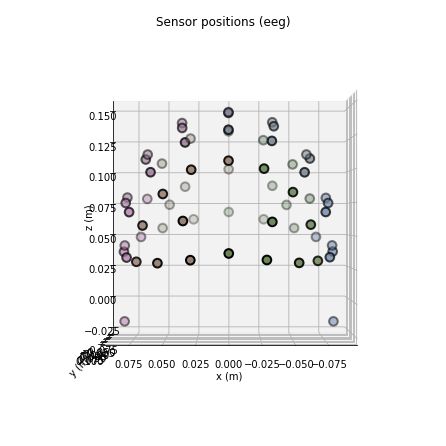

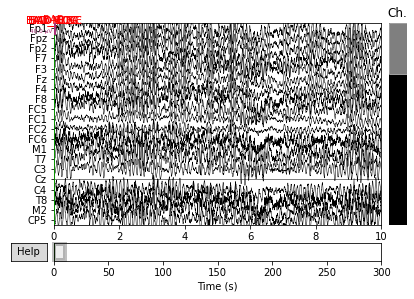

FileNotFoundError: [Errno 2] No such file or directory: '/net/store/nbp/projects/hyperscanning/study_project/NBP_Hyperscanning/data_analysis/bads/bad_segments/test1-annot.csv'

In [3]:
#for subs in ['202','203','204','205','206','207','208','209','211','212']:
for subs in ['202']: # test with one sub

    #subs_path = op.join(subject_dir,"sub-{}_task-hyper_eeg.fif".format(subs))
    subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg-1.fif".format(subs)

    combined_raw = mne.io.read_raw_fif(subs_path, preload=True).crop(tmax=300) # TODO: remove the tmax=300 for the actual stuff

    # 1. Split the subjects and delete the raw file
    sub1_raw, sub2_raw = split_raws(combined_raw)
    del combined_raw
    
    for sub_index, raw in enumerate([sub1_raw, sub2_raw]):
        # create the subject id:
        subj_id = "test" + str(sub_index+1)
        print("\n\n Preprocessing Subject {}\n\n".format(subj_id))

        # 2. Set the EEG reference. We use Cz as a reference
        raw.set_eeg_reference(["Cz"])

        # 3. Apply high pass/low pass filter
        raw.filter(l_freq = 0.1, h_freq = 120) # using firwin
        raw.notch_filter(freqs=[16.666666667, 50])  # bandstop the train and power grid

        # 4. Set the EEG Montage. We use 64 chans from the standard 10-05 system.
        montage = mne.channels.make_standard_montage("standard_1005")
        raw.set_montage(montage)

        # 5. Mark the channels and save them
        mark_bads_and_save(raw, subj_id, sensor_map=True,
                           block=True)

        # 6. HP-filter again at 2Hz for ICA
        raw.filter(l_freq=2, h_freq=None)  
        
        # we should either remove or ignore our annotations before ICA
        # Else, we cannot view single components
        # Don't worry, however. All marked segments are already saved
        raw.set_annotations(None)

        # 7. Run the ICA and save the marked components
        run_ica_and_save(raw, subj_id, block=True,
                         n_components=25, method="fastica")

        # load the bad channels
        #raw.info["bads"] = load_bad_channels(subj_id)

        # add the bad segments to the annotations
        #annots_path = op.join(BAD_SEG_PATH, subj_id + "-annot.csv")
        #annots = mne.read_annotations(annots_path)
        #raw.set_annotations(annots)

        # 8. Load and apply ICA. Marked bad channels are automatically excluded
        ica = mne.preprocessing.read_ica(op.join(BAD_COMP_PATH, subj_id + "-ica.fif"))
        ica.apply(raw)

        # 9. Interpolate bad channels
        raw.interpolate_bads(reset_bads=True)

        # Pick relevant channels:
        # raw.pick_channels() # TODO: define pick channel set here. Do we even need this anymore?

        # 10. Do the surface laplacian
        #raw.plot()
        #raw.plot_psd()
        # TODO: the surface laplacian has parameter lambda and stiffness. Check which fits best
        raw = mne.preprocessing.compute_current_source_density(raw)
        #raw.plot()
        #raw.plot_psd()